In [33]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model, neighbors, ensemble, svm
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE

#to scale certain columns
class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.ix[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]
# to calculate gini index (from kaggle)    
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true



import plotly
plotly.tools.set_credentials_file(username='extralime', api_key='q3tUGZrv40fkKyR4uPuL')
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')

warnings.filterwarnings(
    module='sklearn',
    action='ignore',
    message='Data with')
warnings.filterwarnings("ignore",category=DeprecationWarning)   


colors = cl.to_rgb(cl.scales['10']['div']['BrBG'])
HTML(cl.to_html( cl.scales['10']['div']['BrBG'] ))

## Importing the data

In [34]:
#import the data, manage nulls and date field
df = pd.read_csv('lemon_train.csv')

In [35]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [36]:
df.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,72983.000000,69814.000000,72983.000000,72965.000000,72965.000000,72965.000000,72965.000000,72668.000000,72668.000000,72668.000000,72668.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,36511.428497,0.122988,2005.343052,4.176644,1.494299,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,58043.059945,6730.934326,0.025280,1276.580985
std,21077.241302,0.328425,1.731252,1.712210,0.521290,14578.913128,2461.992768,2722.491986,3156.285284,3385.789541,2434.567723,2686.248852,3090.702941,3310.254351,25717.351219,26151.640415,1767.846435,0.156975,598.846788
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18257.500000,0.000000,2004.000000,3.000000,1.000000,61837.000000,4273.000000,5406.000000,6280.000000,7493.000000,4275.000000,5414.000000,6536.000000,7784.000000,17212.000000,32124.000000,5435.000000,0.000000,837.000000
50%,36514.000000,0.000000,2005.000000,4.000000,1.000000,73361.000000,6097.000000,7303.000000,8444.000000,9789.000000,6062.000000,7313.000000,8729.000000,10103.000000,19662.000000,73108.000000,6700.000000,0.000000,1155.000000
75%,54764.500000,0.000000,2007.000000,5.000000,2.000000,82436.000000,7765.000000,9021.000000,10651.000000,12088.000000,7736.000000,9013.000000,10911.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,45469.000000,1.000000,7498.000000


In [37]:
df.PurchDate = pd.to_datetime(df.PurchDate)
df['pyear'] = df['PurchDate'].dt.year.astype(int)
df['pmonth'] = df['PurchDate'].dt.month.astype(int)
df['pday'] = df['PurchDate'].dt.day.astype(int)
#Drop the date and other columns
df.drop(['RefId', 'BYRNO', 'AUCGUART', 'PRIMEUNIT',
         'VNZIP1','WheelType', 'VehYear','PurchDate'],1,inplace=True)

In [38]:
dnull = df.isnull().sum()
dnullsearch = dnull[dnull>500]
for i in dnullsearch.index:
    comp = df.loc[(df[i].isnull())&(df.IsBadBuy == 1)]
    print(i)
    print('Number of missing lemons: {}'.format(len(comp)))

Trim
Number of missing lemons: 374
WheelTypeID
Number of missing lemons: 2236


If we drop the nulls now, we would lose 2236 lemons, this could negatively impact the model

In [39]:
#Fill missing with most common type
df = df.fillna(df['WheelTypeID'].value_counts().index[0])

In [40]:
df.dropna(inplace=True)
#add 1 to vehicle age (for math)
df.VehicleAge = [x+1 for x in df.VehicleAge]

We split the date into their respective components.
 - Drop columns RefID and BYRNO as these are unique identifiers and could reduce the accuracy.
 - Drop AUGGUART and PRIMEUNIT for missing data (mostly null)
 - Drop VNZIP,WheelType,VehYear, PurchDate as there are other featers in the data to respresent them
 - Fill missing WheelType ID with most common in the set
 - Drop nulls
 - Add 1 year to vehicle age. mathematical convenienve.

In [41]:
print(df.shape)
df.head(3)

(72983, 29)


,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,pyear,pmonth,pday
0,0,ADESA,4,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,...,8552.0,11597.0,12409.0,FL,7100.0,0,1113,2009,12,7
1,0,ADESA,6,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,...,9222.0,11374.0,12791.0,FL,7600.0,0,1053,2009,12,7
2,0,ADESA,5,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,...,5557.0,7146.0,8702.0,FL,4900.0,0,1389,2009,12,7


## Feature Engineering

In [42]:
#Separate and combine columns of interest
models = df.Model
submods = df.SubModel
trims = df.Trim
chars = df[['Model','SubModel','Trim']] 
chars.head(3)

,Model,SubModel,Trim
0,MAZDA3,4D SEDAN I,i
1,1500 RAM PICKUP 2WD,QUAD CAB 4.7L SLT,ST
2,STRATUS V6,4D SEDAN SXT FFV,SXT


In [43]:
#create keyword list for model characteristics
mod_chars = ['2WD','V6','4C','PICKUP','6C','FWD',
             '4WD','AWD','SFI','EFI','DOHC','I4','MPI']

#create keyowrd list for submodel characteristics
submod_chars = ['SEDAN','4D','EXT','CAB','2D','CAB','WAGON',
                'REG','FFV','PASSENGER','SUV','SPORT',
                'UTILITY','QUAD','COUPE','MINIVAN','CUV']

#Create a dataframe and extract keywords from model and submodel.
sub_val_sets, mod_val_sets = pd.DataFrame(),pd.DataFrame()

for key in submod_chars:
    subs = np.where(submods.str.contains(key),1,0) #create array for dummied char prescence    
    sub_val_sets[key] = subs #insert to dataframe
for key in mod_chars:
    mods = np.where(models.str.contains(key),1,0)
    mod_val_sets[key] = mods

#combine the two characteristic sets
char_dummies = pd.concat([mod_val_sets,sub_val_sets],axis=1)  

#remove engine displacement size
displacement = chars.SubModel.str.split('.').reset_index()


#Only keep entries with engine size len(Submodel) == 2
disp_ok = []
modls = list(displacement.SubModel.dropna())
for i in modls:
    if len(i) == 2:
        disp_ok.append(i)
        
#Finally take the last element from 1st list, insert '.' add lasr element of 2nd list
displacements = []
for i in range(len(disp_ok)):
    beg = disp_ok[i][0][-1]
    end = disp_ok[i][1][0]
    whole = beg+'.'+end
    displacements.append(whole)
displacements = pd.Series(displacements)
ds_val_cnts = displacements.value_counts().reset_index()

#create dummie matrix for engine displacements
disp_keys = pd.DataFrame()
for key in ds_val_cnts['index']:
    dsps = np.where(df.SubModel.str.contains(key),1,0) #create array for dummied char prescence    
    disp_keys[key] = dsps #insert to dataframe
char_dummies.head(3)

,2WD,V6,4C,PICKUP,6C,FWD,4WD,AWD,SFI,EFI,...,REG,FFV,PASSENGER,SUV,SPORT,UTILITY,QUAD,COUPE,MINIVAN,CUV
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [44]:
disp_keys.head(3)

,3.5,4.2,3.3,4.7,3.0,3.9,2.2,4.6,4.0,2.7,...,5.6,2.8,2.0,5.9,6.0,3.6,2.9,8.1,5.2,6.2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#Isolate continuous attributes
plodf= df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
 'VehicleAge','VehOdo','WarrantyCost','IsBadBuy']].copy()
plodf.dropna(inplace=True)
#transform and reduce
plodf['crcp_cacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['crcp_cacp_war'] = plodf['crcp_cacp']* df.WarrantyCost/df.VehicleAge
plodf['log_war_age'] = df.WarrantyCost/df.VehicleAge
plodf['odo_age'] = np.log(df.VehOdo/df.VehicleAge)
        
cont_df = plodf[['odo_age','log_war_age','crcp_cacp_war']]

In [46]:
#combine the four new feature dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)
cont_df.reset_index(drop=True,inplace=True)

add_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys,cont_df],axis=1)

#combine new features to our existing attributes
df.reset_index(drop=True,inplace=True)
model_df = pd.concat([df,add_feats],axis=1)

#general clean up
model_df.drop(['SubModel'],1,inplace=True)
model_df.Model = model_df.Model.str.split().str[0].str.strip()
model_df.Transmission = np.where(model_df.Transmission == 'AUTO',1,0)


In [47]:
model_df['avg_price'] = (model_df.MMRAcquisitionAuctionAveragePrice+model_df.MMRAcquisitionAuctionCleanPrice+\
                         model_df.MMRAcquisitionRetailAveragePrice+model_df.MMRAcquisitonRetailCleanPrice+\
                         model_df.MMRCurrentAuctionAveragePrice+model_df.MMRCurrentAuctionCleanPrice+\
                         model_df.MMRCurrentRetailAveragePrice+model_df.MMRCurrentRetailCleanPrice)/8
model_df['Exp_Margin'] = model_df.avg_price-model_df.VehBCost

In [48]:
class1 = model_df[model_df.IsBadBuy == 1]
class0 = model_df[model_df.IsBadBuy == 0]

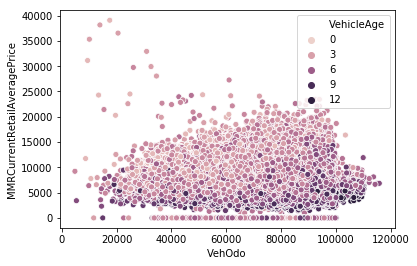

In [49]:
sns.scatterplot(x='VehOdo',y='MMRCurrentRetailAveragePrice',hue='VehicleAge',data=model_df, cmap='mako_r')

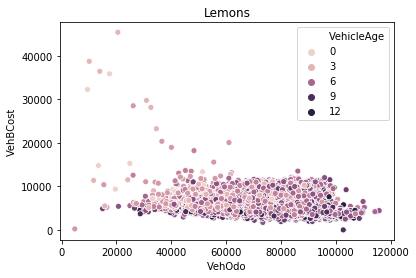

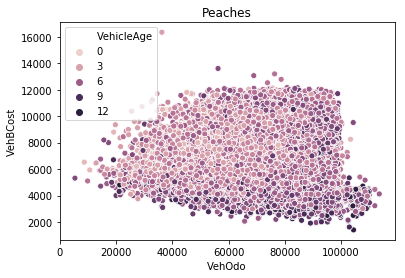

In [50]:
sns.scatterplot(x='VehOdo',y='VehBCost',hue='VehicleAge',data=class1, cmap='mako_r')
plt.title("Lemons")
plt.show()
sns.scatterplot(x='VehOdo',y='VehBCost',hue='VehicleAge',data=class0, cmap='mako_r')
plt.title('Peaches')
plt.show()

In [121]:

mod_counts = model_df.Model.value_counts().reset_index().sort_values(by='index')['Model'].reset_index()
all_mods['mod_counts'] = mod_counts.Model

In [83]:
lem_mods = model_df[model_df.IsBadBuy == 1]
lem_mods.head()

,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,Color,Transmission,WheelTypeID,VehOdo,...,3.6,2.9,8.1,5.2,6.2,odo_age,log_war_age,crcp_cacp_war,avg_price,Exp_Margin
12,1,ADESA,5,DODGE,CARAVAN,SE,RED,1,1.0,79315,...,0,0,0,0,0,9.671745,324.600000,1.313656e+06,7144.250,1744.250
25,1,ADESA,6,MERCURY,SABLE,LS,WHITE,1,1.0,52106,...,0,0,0,0,0,9.069276,125.666667,4.647153e+05,5270.750,770.750
31,1,ADESA,8,FORD,EXPLORER,Spo,BLUE,1,1.0,56300,...,0,0,0,0,0,8.859008,152.500000,3.990925e+05,4877.875,-22.125
35,1,ADESA,9,FORD,WINDSTAR,LX,GOLD,1,1.0,82944,...,0,0,0,0,0,9.128696,258.000000,7.456200e+05,3565.625,-34.375
39,1,ADESA,6,FORD,MUSTANG,Bas,GOLD,1,1.0,65078,...,0,0,0,0,0,9.291582,121.333333,5.250093e+05,10209.250,1709.250


In [87]:
lem_count = lem_mods.Model.value_counts().reset_index().sort_values(by='index')


,index,Model
11,1500,199
209,1500HD,1
173,2500,2
139,2500HD,4
122,3.2,6


In [328]:
all_mods1 = model_df.groupby('Model')['VehicleAge','VehOdo','avg_price',
                                   'Exp_Margin','VehBCost','WarrantyCost'].mean().reset_index()
all_mods1['vic_cnt'] = model_df.Model.value_counts().reset_index().sort_values(by='index').reset_index()['Model']

diffs = list(set(model_df.Model.unique()).difference(class1.Model.unique()))
index_dict = dict((value, idx) for idx,value in enumerate(all_mods1.Model))
poss = [index_dict[x] for x in diffs]

all_mods1 = all_mods1.drop([233, 169, 179, 124, 70, 147, 244,
                            66, 113, 121, 126, 54, 218, 108, 
                            137, 166, 240, 159,104, 191, 105,
                            187, 139, 91, 19, 195, 153, 210, 
                            101, 207, 188, 127, 237, 182, 115,
                            197, 80]).reset_index().drop(['index'],1)
all_mods1['lem_cnt'] = class1.Model.value_counts().reset_index().sort_values(by='index').reset_index()['Model']
all_mods1['lem_pct'] = round(all_mods1.lem_cnt/all_mods1.vic_cnt,2)
all_mods1.head()

,Model,VehicleAge,VehOdo,avg_price,Exp_Margin,VehBCost,WarrantyCost,vic_cnt,lem_cnt,lem_pct
0,1500,5.952910,77272.132804,9648.591667,873.273148,8775.318519,1115.538624,1890,199,0.11
1,1500HD,7.333333,87215.111111,10775.027778,369.472222,10405.555556,1635.555556,9,1,0.11
2,2500,6.000000,81398.388889,9309.618056,-643.437500,9953.055556,1239.166667,18,2,0.11
3,2500HD,6.181818,84120.090909,7613.500000,-1181.954545,8795.454545,1351.454545,11,4,0.36
4,3.2,7.947368,81114.842105,7357.197368,-669.118421,8026.315789,1542.789474,19,6,0.32


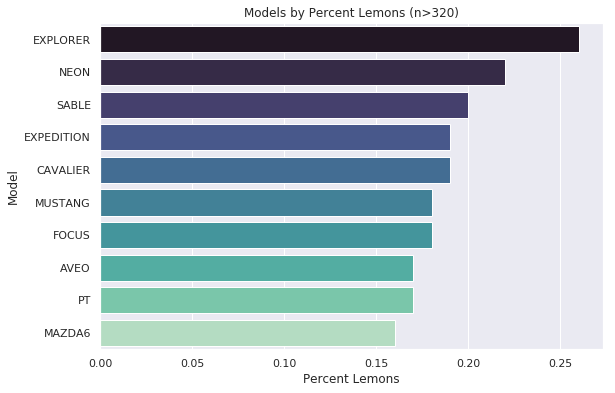

In [331]:
sns.set(palette='mako_r')
plt.figure(figsize=(9,6))

sns.barplot(y=all_mods1[all_mods1.vic_cnt > 321].sort_values(by='lem_pct',ascending=False)['Model'][:10],
            x=all_mods1[all_mods1.vic_cnt > 321].sort_values(by='lem_pct',ascending=False)['lem_pct'][:10],
            palette='mako')
plt.title('Models by Percent Lemons (n>320)')
plt.ylabel('Model')
plt.xlabel('Percent Lemons')
plt.savefig('lemonsbymodel.png')

In [347]:
margs = model_df.groupby(['Make','Model'])['Exp_Margin'].mean().groupby('Make').head().reset_index()
margs.Exp_Margin = [round(x,2) for x in margs.Exp_Margin]
margs.head()

,Make,Model,Exp_Margin
0,ACURA,3.2,-669.12
1,ACURA,MDX,315.02
2,ACURA,RSX,-649.31
3,ACURA,TL,1322.88
4,ACURA,TSX,2546.53


In [374]:
acc = list(margs[margs.Make == 'ACURA'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
accmods = list(margs[margs.Make == 'ACURA'].sort_values(by='Exp_Margin',ascending=False)['Model'])

ch = list(margs[margs.Make == 'CHEVROLET'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
chmods = list(margs[margs.Make == 'CHEVROLET'].sort_values(by='Exp_Margin',ascending=False)['Model'])

nis = list(margs[margs.Make == 'KIA'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
nismods = list(margs[margs.Make == 'KIA'].sort_values(by='Exp_Margin',ascending=False)['Model'])

toy = list(margs[margs.Make == 'TOYOTA'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
toymods = list(margs[margs.Make == 'TOYOTA'].sort_values(by='Exp_Margin',ascending=False)['Model'])

In [375]:
acc[0],ch[0],nis[0],toy[0]
accmods[0],chmods[0],nismods[0],toymods[0]

('TSX', '1500', 'RONDO', 'AVALON')

In [381]:
x = ['Acura', 'Chrysler','Kia','Toyota']
y = [acc[0],ch[0],nis[0],toy[0]]
y2 = [acc[1],ch[1],nis[1],toy[1]]
y3 = [acc[2],ch[2],nis[2],toy[2]]
y4 = [acc[3],ch[3],nis[3],toy[3]]
trace1 = go.Bar(
    x=x,
    y=y,
    text=[accmods[0],chmods[0],nismods[0],toymods[0]],
    textposition = 'auto',
    marker=dict(
        color=colors[8]
        ),
    opacity=0.9
)

trace2 = go.Bar(
    x=x,
    y=y2,
    text=[accmods[1],chmods[1],nismods[1],toymods[1]],
    textposition = 'auto',
    marker=dict(
        color=colors[6]),

        
    opacity=0.8
)
trace3 = go.Bar(
    x=x,
    y=y3,
    text=[accmods[2],chmods[2],nismods[2],toymods[2]],
    textposition = 'auto',
    marker=dict(
        color=colors[4],
        
        ),
    opacity=0.7
)
trace4 = go.Bar(
    x=x,
    y=y4,
    text=[accmods[3],chmods[3],nismods[3],toymods[3]],
    textposition = 'auto',
    marker=dict(
        color=colors[2]),
    opacity=0.6
)

data = [trace1,trace2,trace3,trace4]

py.iplot(data, filename='profmod_make')

In [274]:
all_makes = model_df.groupby('Make')['VehicleAge','VehOdo','avg_price',
                                   'Exp_Margin','VehBCost','WarrantyCost'].mean().reset_index()
all_makes['vic_cnt'] = model_df.Make.value_counts().reset_index().sort_values(by='index').reset_index()['Make']
diff = list(set(model_df.Make.unique()).difference(class1.Make.unique()))
all_makes = all_makes.drop([32,30,9]).reset_index().drop(['index'],1)
all_makes['lem_cnt'] = class1.Make.value_counts().reset_index().sort_values(by='index').reset_index()['Make']
all_makes['lem_pct'] = round(all_makes.lem_cnt/all_makes.vic_cnt,2)
all_makes.head()

,Make,VehicleAge,VehOdo,avg_price,Exp_Margin,VehBCost,WarrantyCost,vic_cnt,lem_cnt,lem_pct
0,ACURA,7.515152,81732.363636,9091.303030,52.060606,9039.242424,1471.424242,33,9,0.27
1,BUICK,6.654167,76237.602778,7484.048264,1314.807986,6169.240278,2406.676389,720,113,0.16
2,CADILLAC,6.242424,73770.121212,12623.875000,1665.420455,10958.454545,1857.636364,33,5,0.15
3,CHEVROLET,4.974316,73390.077922,8187.077299,1352.112234,6834.965065,1543.303803,17248,1681,0.10
4,CHRYSLER,4.652985,66814.413501,7804.698016,1297.349474,6507.348541,1280.819878,8844,1137,0.13


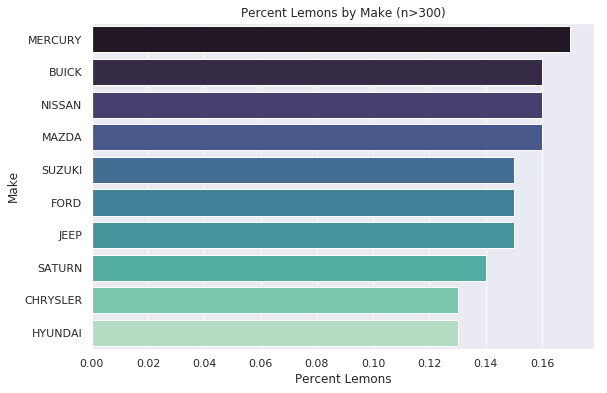

In [279]:
sns.set(palette='mako_r')
plt.figure(figsize=(9,6))

sns.barplot(y=all_makes[all_makes.vic_cnt>321].sort_values(by='lem_pct',ascending=False)['Make'][:10],
            x=all_makes[all_makes.vic_cnt>321].sort_values(by='lem_pct',ascending=False)['lem_pct'][:10],
            palette='mako')
plt.title('Percent Lemons by Make (n>300)')
plt.ylabel('Make')
plt.xlabel('Percent Lemons')
plt.savefig('lemonsbymake.png')

In [384]:
corrs = pd.concat([char_dummies,disp_keys],1)

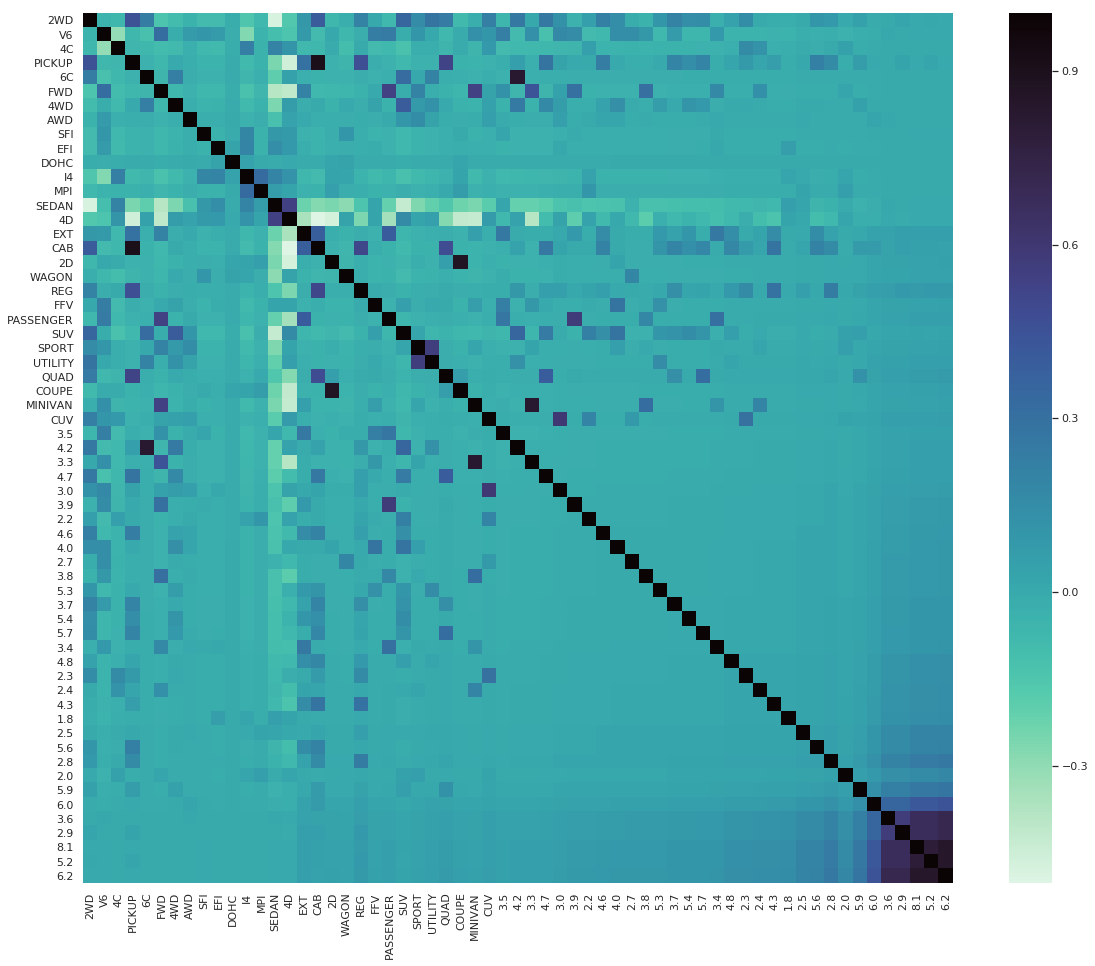

In [385]:
corrmat = corrs.corr()
with sns.axes_style('white'):    
    ax = plt.subplots(figsize=(20,16))

    sns.heatmap(corrmat,
            vmax=1, 
            cmap="mako_r",            
            
            square=True)
           


plt.savefig('carcorrheatlemon.png')

In [387]:
print(corrmat.shape)
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.
c = c.loc[(c[0]!=1)&(c[0]>.75)]
c.sort_values(by=0,ascending=False)

(61, 61)


,level_0,level_1,0
199,PICKUP,CAB,0.911014
979,CAB,PICKUP,0.911014
1063,2D,COUPE,0.874932
1603,COUPE,2D,0.874932
3598,8.1,6.2,0.843254
3718,6.2,8.1,0.843254
3659,5.2,6.2,0.843254
3719,6.2,5.2,0.843254
274,6C,4.2,0.828402
1834,4.2,6C,0.828402


In [390]:
counthese = c.level_0
for col in counthese:
    print(col,corrs[col].sum())

PICKUP 3280
6C 1909
CAB 3916
2D 3362
COUPE 2676
MINIVAN 3304
4.2 2377
3.3 2326
8.1 10
8.1 10
5.2 10
5.2 10
6.2 9
6.2 9
